In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import numpy as np
import os
import io
import warnings
import keras
import regex as re
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D,Conv2D,Dropout,MaxPooling1D,Flatten
from unidecode import unidecode
import en_core_web_md
nlp = en_core_web_md.load()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix

EDA

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.shape

(7613, 5)

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
train.shape

(7613, 5)

The missing values of the "keyword" column represent less than 1% of the dataset, it is kept.
We eliminate the "location" column to have too many missing values.

In [7]:
train = train[[col for col in train.columns if col != 'location']]
train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We look at the unique values of the 'keyword' column.

In [261]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desol

We replace the "%20" with a space.

In [9]:
def replace20(x):
    
    try: 
        return x.replace('%20',' ')
    except AttributeError:
        return x

train['keyword'] = train['keyword'].apply(replace20)

train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
train.groupby('keyword')['target'].mean().sort_values(ascending = False)

keyword
debris        1.000000
wreckage      1.000000
derailment    1.000000
outbreak      0.975000
oil spill     0.973684
                ...   
body bag      0.030303
blazing       0.029412
ruin          0.027027
body bags     0.024390
aftershock    0.000000
Name: target, Length: 221, dtype: float64

In [11]:
train["text"] = train["text"].apply(lambda x: str(x).lower())

In [12]:
train['is arobase']= train['text'].apply(lambda x:str(x).find('@') != -1).astype(int)

In [13]:
train['is arobase'].mean()

0.26783134112701956

In [262]:
print('If the tweet contains @, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is arobase')['target'].mean().loc[1],2))

print('If the tweet does not contain @, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is arobase')['target'].mean().loc[0],2))

If the tweet contains @, then the probability that it indicates a natural disaster is 0.33
If the tweet does not contain @, then the probability that it indicates a natural disaster is 0.47


In [15]:
train['is hashtag'] = train['text'].apply(lambda x:str(x).find('#') != -1).astype(int)

train['is hashtag'].mean()

0.2313148561670826

In [263]:
print('If the tweet contains #, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is hashtag')['target'].mean().loc[1],2))

print('If the tweet does not contain #, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is hashtag')['target'].mean().loc[0],2))

If the tweet contains #, then the probability that it indicates a natural disaster is 0.5
If the tweet does not contain #, then the probability that it indicates a natural disaster is 0.41


Pre-processing

In [18]:
train['text'] = train['text'].apply(unidecode)

We create a function that cleans the texts.

In [30]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stops = set(stopwords.words('english'))
import spacy
sp = spacy.load('en_core_web_sm')

spacy_stopwords = sp.Defaults.stop_words

stops = stops.union(spacy_stopwords)

stops = stops.union({' ','.',',','',"i'm",'u','rt','http','like','//t','girl','girls',"'",'"','mkr'})

def remove_stop_words(words):

   return [word.lower() for word in words if word.lower() not in stops]  

import textcleaner as tc


def clean_text(text): 
    
  token_text = nlp(text)
    
  text = [element.lemma_.lower() for element in token_text]  

  clean_text = remove_stop_words(text)  
    
  text = " ".join(clean_text).strip().lower()  
  
  text = re.sub(r'[0-9]+','',text).strip()
  text = re.sub(r'[@]+','@',text).strip()
  text = re.sub(r'@','@ ', text).strip()  
  text = re.sub(r'[#]+','#',text).strip()
  text = re.sub(r'#','# ', text).strip() 
#  text = re.sub(r'\x[0-9]+','',text).strip()  
  text = re.sub(r'rt[\s]+','', text).strip()
  text = re.sub(r"[,.\"!$%^&*(){}?/;`~:<>_+=-]", "", text).strip()
  text = re.sub(r'http[A-Za-z0-9]+','', text).strip()
  text = re.sub(r'bbc','',text) .strip() 
  emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji.sub(r'', text).strip()   
  text = re.sub(r"i'm", "i am", text).strip()
  text = re.sub(r"he's", "he is", text).strip()
  text = re.sub(r"she's", "she is", text).strip()
  text = re.sub(r"that's", "that is", text).strip()        
  text = re.sub(r"what's", "what is", text).strip()
  text = re.sub(r"where's", "where is", text).strip() 
  text = re.sub(r"\'ll", " will", text).strip()  
  text = re.sub(r"\'ve", " have", text).strip()  
  text = re.sub(r"\'re", " are", text).strip()
  text = re.sub(r"\'d", " would", text).strip()
  text = re.sub(r"\'ve", " have", text).strip()
  text = re.sub(r"won't", "will not", text).strip()
  text = re.sub(r"don't", "do not", text).strip()
  text = re.sub(r"did't", "did not", text).strip()
  text = re.sub(r"can't", "can not", text).strip()
  text = re.sub(r"it's", "it is", text).strip()
  text = re.sub(r"couldn't", "could not", text).strip()
  text = re.sub(r"have't", "have not", text).strip()
  text = re.sub(r'[\s]+',' ',text)
    
  text = text.lower()   
    
#  text = remove_stop_words2(text).strip()

#  text = " ".join(text).strip()
 
  return text.split(" ")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


In [31]:
train['token_text'] = train['text'].apply(clean_text)

train['text_cleaned'] = train['token_text'].apply(lambda x : " ".join(x))
train

,id,keyword,text,target,is arobase,is hashtag,token_text,text_cleaned,keyword_cleaned,keyword_text_cleaned
0,1,NaN,our deeds are the reason of this #earthquake m...,1,0,1,"[deed, reason, #, earthquake, allah, forgive]",deed reason # earthquake allah forgive,,deed reason # earthquake allah forgive
1,4,NaN,forest fire near la ronge sask. canada,1,0,0,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,,forest fire near la ronge sask canada
2,5,NaN,all residents asked to 'shelter in place' are ...,1,0,0,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...,,resident ask ' shelter place ' notify officer...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,0,1,"[people, receive, #, wildfire, evacuation, ord...",people receive # wildfire evacuation order cal...,,people receive # wildfire evacuation order ca...
4,7,NaN,just got sent this photo from ruby #alaska as ...,1,0,1,"[got, send, photo, ruby, #, alaska, smoke, #, ...",got send photo ruby # alaska smoke # wildfire ...,,got send photo ruby # alaska smoke # wildfire...
...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,two giant cranes holding a bridge collapse int...,1,0,0,"[giant, crane, hold, bridge, collapse, nearby,...",giant crane hold bridge collapse nearby home,,giant crane hold bridge collapse nearby home
7609,10870,NaN,@aria_ahrary @thetawniest the out of control w...,1,1,0,"[@, ariaahrary, @, thetawni, control, wild, fi...",@ ariaahrary @ thetawni control wild fire cali...,,@ ariaahrary @ thetawni control wild fire cal...
7610,10871,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,0,0,"[m, [, utc], km, volcano, hawaii]",m [ utc] km volcano hawaii,,m [ utc] km volcano hawaii
7611,10872,NaN,police investigating after an e-bike collided ...,1,0,0,"[police, investigate, e, bike, collide, car, l...",police investigate e bike collide car little p...,,police investigate e bike collide car little ...


In [32]:
def clean_keyword(x):
    
    try:
        clean_token = clean_text(x)
        return " ".join(clean_token)
    except ValueError:
        return ""

train['keyword_cleaned'] = train['keyword'].apply(clean_keyword)

In [33]:
train.iloc[:,[1,-1]].sample(16)

,keyword,keyword_text_cleaned
3527,eyewitness,eyewitness aug radio article uo ] eyewitness a...
115,aftershock,aftershock [ ir ] icemoon [ aftershock ] | | @...
1250,buildings on fire,building fire band building fire play @ introd...
1770,collision,collision solano sr skaggs island rd trfc coll...
3679,fatality,fatality afghan soldier kill general america h...
4313,hellfire,hellfire hellfire surround desire careful donu...
142,airplane accident,airplane accident man airplane engine accident...
4610,injury,injury dal news wednesday injury repo rb lance...
7147,volcano,volcano architect kanye westuas volcano
4395,hijacking,hijacking murderous story americauas hijacking...


In [34]:
train['keyword_text_cleaned'] = train.keyword_cleaned + ' ' + train.text_cleaned

We look at the word clouds associated with each value of the target.

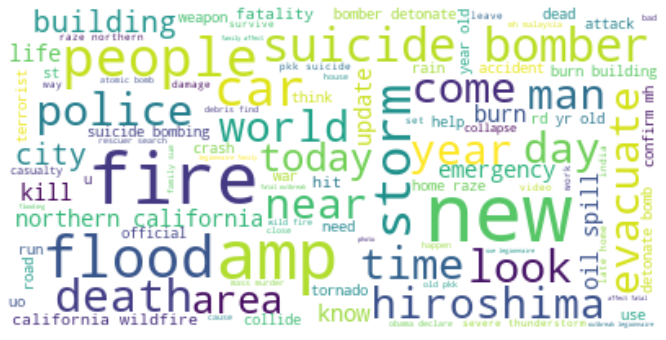

In [35]:
import matplotlib.pyplot as plt

text = " ".join(review for review in train[train['target'] == 1]['token_text'].apply(lambda x : " ".join(x)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

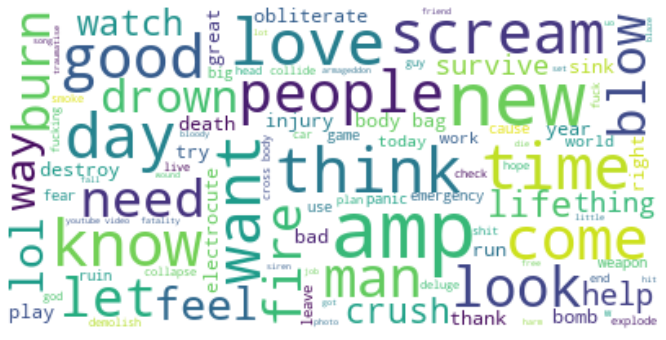

In [36]:
text = " ".join(review for review in train[train['target'] == 0]['token_text'].apply(lambda x : " ".join(x)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
list_words_df3_label1 = []

for words in train[train['target'] == 1]['token_text'].tolist():
    list_words_df3_label1 += words

list_words_df3_label0 = []

for words in train[train['target'] == 0]['token_text'].tolist():
    list_words_df3_label0 += words

In [38]:
pd.DataFrame({'words':list_words_df3_label1}).value_counts().sort_values(ascending = False)[:10]

words     
#             1679
@              885
fire           268
kill           156
news           141
disaster       121
california     115
bomb           113
year           112
crash          112
dtype: int64

In [39]:
pd.DataFrame({'words':list_words_df3_label0}).value_counts().sort_values(ascending = False)[:10]

words
@        1827
#        1670
amp       193
new       172
good      120
body      119
love      117
come      108
time      106
video     103
dtype: int64

Train models

In [40]:
train['target'].mean()

0.4296597924602653

This is an unbalanced dataframe.

Model 1: with @ and #.

In [41]:
df = train.copy()

In [42]:
import numpy as np
tokenizer1 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer1.fit_on_texts(df.keyword_text_cleaned)
df["text_encoded"] = tokenizer1.texts_to_sequences(df.text_cleaned)
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))

In [43]:
df1 = df[df["len_text"]!=0]

text_pad1 = tf.keras.preprocessing.sequence.pad_sequences(df1.text_encoded, padding="post")

y = df1['target'].values

In [44]:
keyword_pad1 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer1.texts_to_sequences(df1.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad1 = np.concatenate([keyword_pad1,text_pad1],axis = 1)

In [45]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad1,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [46]:
vocab_size = tokenizer1.num_words
model1 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"),
                  Conv1D(
filters = 4, # the number of neurons on the convolutional layer
kernel_size = (5), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "valid", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = 'l2' # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
                  keras.layers.Dense(50, activation='relu'),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
#                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(1, activation="sigmoid")
])

In [47]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 conv1d (Conv1D)             (None, 13, 4)             2564      
                                                                 
 global_average_pooling1d (G  (None, 4)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 50)                250       
                                                                 
 dense_1 (Dense)             (None, 16)                816       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                        

In [48]:
optimizer= keras.optimizers.Adam()

model1.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model1.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=20, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/20
50/50 [==============================] - 2s 13ms/step - loss: 0.2823 - mean_absolute_error: 0.4909 - val_loss: 0.2482 - val_mean_absolute_error: 0.4782
Epoch 2/20
50/50 [==============================] - 0s 7ms/step - loss: 0.2169 - mean_absolute_error: 0.4392 - val_loss: 0.1988 - val_mean_absolute_error: 0.3956
Epoch 3/20
50/50 [==============================] - 0s 8ms/step - loss: 0.1696 - mean_absolute_error: 0.3475 - val_loss: 0.1761 - val_mean_absolute_error: 0.3498
Epoch 4/20
50/50 [==============================] - 0s 7ms/step - loss: 0.1403 - mean_absolute_error: 0.2875 - val_loss: 0.1678 - val_mean_absolute_error: 0.3141
Epoch 5/20
50/50 [==============================] - 0s 9ms/step - loss: 0.1276 - mean_absolute_error: 0.2682 - val_loss: 0.1712 - val_mean_absolute_error: 0.2891
Epoch 6/20
50/50 [==============================] - 0s 8ms/step - loss: 0.1293 - mean_absolute_error: 0.2582 - val_loss: 0.1635 - val_mean_absolute_error: 0.3112
Epoch 7/20
50/50 [=========

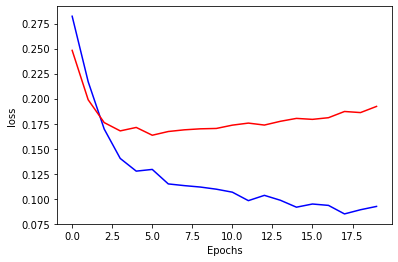

In [49]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [50]:
df['keyword_cleaned'].unique()

array(['', 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilate', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'avalanche',
       'battle', 'bioterror', 'bioterrorism', 'blaze', 'bleeding', 'blow',
       'blight', 'blizzard', 'blood', 'bloody', 'body bag',
       'body bagging', 'bomb', 'bombing', 'bridge collapse',
       'building burn', 'building fire', 'burn', 'burning',
       'burn building', 'bush fire', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collide', 'collision', 'crash', 'crush', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'debris', 'deluge',
       'demolish', 'demolition', 'derail', 'derailment', 'desolate',
       'desolation', 'destroy', 'destruction', 'detonate', 'detonation',
       'devastate', 'devastation', 'disaster', 'displace', 'drought',
       'drown', 'dust storm', 'earthquake', 'electrocute',

In [51]:
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

48/48 [==============================] - 0s 2ms/step


In [52]:
np.array(y_train).mean()

0.4318834179730625

In [53]:
np.array(y_val).mean()

0.43178807947019865

In [54]:
print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' , f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.9081474939280194
accuracy score test : 0.7655629139072848
f1 score train : 0.8939316675165732
f1 score test : 0.7358208955223882


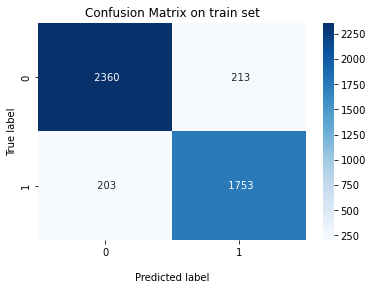

In [55]:
import seaborn as sns
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

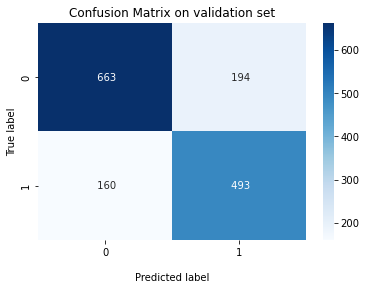

In [56]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on validation set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

In [57]:
df1['pred prob target'] = model1.predict(text_pad1)
df1['pred target'] = df1['pred prob target'].apply(lambda x : x>0.5)

236/236 [==============================] - 1s 2ms/step


In [58]:
size = ((df1.target == 1)&(df1['pred target'] == 0)).sum()

idx = np.random.randint(size)

df1[(df1.target == 1)&(df1['pred target'] == 0)].iloc[idx]['text']

"@modnao23 the hail is ruining everything. plus my car i haven't even gotten yet. have yet another killer migraine and i lost my glasses. ??"

Model2: same model than model1 but we eliminate @ and #.

In [137]:
df_bis = df.copy()

df_bis['text'] = df_bis['text'].apply(lambda x : re.sub('[@#]','',x))

tokenizer2 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer2.fit_on_texts(df_bis.keyword_text_cleaned)
df_bis["text_encoded"] = tokenizer2.texts_to_sequences(df_bis.text_cleaned)
df_bis["len_text"] = df_bis["text_encoded"].apply(lambda x: len(x))

df2 = df_bis[df_bis["len_text"]!=0]

text_pad2 = tf.keras.preprocessing.sequence.pad_sequences(df2.text_encoded, padding="post")

y = df2['target'].values

keyword_pad2 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer2.texts_to_sequences(df2.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad2 = np.concatenate([keyword_pad2,text_pad2],axis = 1)

In [138]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad2,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [139]:
vocab_size = tokenizer2.num_words
model2 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"),
                  Conv1D(
filters = 4, # the number of neurons on the convolutional layer
kernel_size = (5), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "valid", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = None # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
#                  keras.layers.Dense(50, activation='relu'),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
#                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(1, activation="sigmoid")
])

In [140]:
optimizer= keras.optimizers.Adam()

model2.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model2.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=8, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/8
50/50 [==============================] - 2s 14ms/step - loss: 0.2395 - mean_absolute_error: 0.4827 - val_loss: 0.2333 - val_mean_absolute_error: 0.4693
Epoch 2/8
50/50 [==============================] - 0s 9ms/step - loss: 0.2113 - mean_absolute_error: 0.4484 - val_loss: 0.1847 - val_mean_absolute_error: 0.4081
Epoch 3/8
50/50 [==============================] - 0s 8ms/step - loss: 0.1612 - mean_absolute_error: 0.3617 - val_loss: 0.1507 - val_mean_absolute_error: 0.3238
Epoch 4/8
50/50 [==============================] - 0s 9ms/step - loss: 0.1318 - mean_absolute_error: 0.2877 - val_loss: 0.1489 - val_mean_absolute_error: 0.3078
Epoch 5/8
50/50 [==============================] - 1s 10ms/step - loss: 0.1201 - mean_absolute_error: 0.2605 - val_loss: 0.1470 - val_mean_absolute_error: 0.2880
Epoch 6/8
50/50 [==============================] - 1s 11ms/step - loss: 0.1148 - mean_absolute_error: 0.2460 - val_loss: 0.1492 - val_mean_absolute_error: 0.2783
Epoch 7/8
50/50 [==============

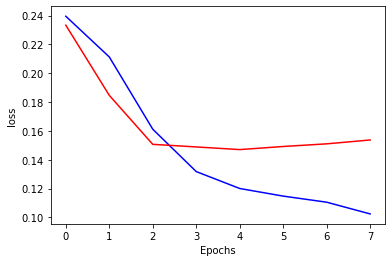

In [141]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [142]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

48/48 [==============================] - 0s 2ms/step


In [143]:
print('accuracy score train :', accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :', accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' ,  f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.8703908147493928
accuracy score test : 0.7940397350993378
f1 score train : 0.8352511928150435
f1 score test : 0.7406171809841534


The results are better. We now test a new model where we use Long short-term memory. 

model3

In [205]:
tokenizer3 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer3.fit_on_texts(df.keyword_text_cleaned)

df3 = df.copy()

tweet_pads3 = tokenizer3.texts_to_sequences(df3.text_cleaned)

In [206]:
tweet_pads3 = tf.keras.preprocessing.sequence.pad_sequences(tweet_pads3, padding="post")

In [207]:
keyword_pads3 = tokenizer3.texts_to_sequences(df3.keyword_cleaned.tolist())

In [208]:
keyword_pads3 = tf.keras.preprocessing.sequence.pad_sequences(keyword_pads3, padding="post")

In [209]:
keyword_tweet_pads3 = np.concatenate([keyword_pads3,tweet_pads3],axis = 1)

In [210]:
y = df3['target']

In [211]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_tweet_pads3,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [212]:
X_test.shape

(1523, 17)

In [219]:
model3 = keras.models.Sequential()

model3.add(keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"))

model3.add(keras.layers.Bidirectional(keras.layers.LSTM(15,dropout=0.2)))# LSTM layer

model3.add(keras.layers.Dropout(0.2))

model3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(1, activation='sigmoid'))
#reg_model.name = 'L2 Regularization model'

In [220]:
model3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 bidirectional_6 (Bidirectio  (None, 30)               17280     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 30)                0         
                                                                 
 dense_41 (Dense)            (None, 64)                1984      
                                                                 
 dense_42 (Dense)            (None, 64)                4160      
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                     

In [221]:
optimizer= keras.optimizers.Adam()

model3.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [222]:
# Entrainement du modèle 
history = model3.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=8, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/8
50/50 [==============================] - 9s 54ms/step - loss: 0.3489 - mean_absolute_error: 0.4825 - val_loss: 0.3029 - val_mean_absolute_error: 0.4607
Epoch 2/8
50/50 [==============================] - 1s 28ms/step - loss: 0.2437 - mean_absolute_error: 0.3702 - val_loss: 0.2091 - val_mean_absolute_error: 0.3187
Epoch 3/8
50/50 [==============================] - 1s 28ms/step - loss: 0.1821 - mean_absolute_error: 0.2848 - val_loss: 0.1831 - val_mean_absolute_error: 0.2958
Epoch 4/8
50/50 [==============================] - 1s 28ms/step - loss: 0.1522 - mean_absolute_error: 0.2512 - val_loss: 0.1744 - val_mean_absolute_error: 0.2884
Epoch 5/8
50/50 [==============================] - 1s 29ms/step - loss: 0.1373 - mean_absolute_error: 0.2382 - val_loss: 0.1727 - val_mean_absolute_error: 0.2682
Epoch 6/8
50/50 [==============================] - 1s 28ms/step - loss: 0.1289 - mean_absolute_error: 0.2317 - val_loss: 0.1739 - val_mean_absolute_error: 0.2562
Epoch 7/8
50/50 [===========

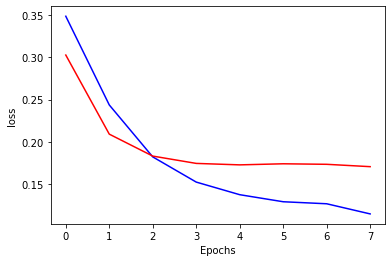

In [223]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [224]:
y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)

print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train : ' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test : ' ,  f1_score(y_test,y_test_pred>0.5))

48/48 [==============================] - 0s 6ms/step
accuracy score train : 0.8876724326691482
accuracy score test : 0.7754432042022325
f1 score train :  0.8630904723779024
f1 score test :  0.7259615384615385


Results are not better that before than model2. We now do the same removing @ and #.

In [225]:
df_bis = df.copy()

df_bis['text'] = df_bis['text'].apply(lambda x : re.sub('[@#]','',x))

tokenizer4 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer4.fit_on_texts(df_bis.keyword_text_cleaned)
df_bis["text_encoded"] = tokenizer4.texts_to_sequences(df_bis.text_cleaned)
df_bis["len_text"] = df_bis["text_encoded"].apply(lambda x: len(x))

df4 = df_bis[df_bis["len_text"]!=0]

text_pad4 = tf.keras.preprocessing.sequence.pad_sequences(df4.text_encoded, padding="post")

y = df4['target'].values

keyword_pad4 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer4.texts_to_sequences(df4.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad4 = np.concatenate([keyword_pad4,text_pad4],axis = 1)

In [226]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad4,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [227]:
model4 = keras.models.Sequential()

model4.add(keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"))

model4.add(keras.layers.Bidirectional(keras.layers.LSTM(15,dropout=0.2)))# LSTM layer

model4.add(keras.layers.Dropout(0.2))

model4.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=(X_train.shape[1],)))

model4.add(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model4.add(keras.layers.Dense(1, activation='sigmoid'))
#reg_model.name = 'L2 Regularization model'

In [228]:
model4.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 bidirectional_7 (Bidirectio  (None, 30)               17280     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 30)                0         
                                                                 
 dense_45 (Dense)            (None, 64)                1984      
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 1)                 33        
                                                     

In [229]:
optimizer= keras.optimizers.Adam()

model4.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [230]:
# Entrainement du modèle 
history = model3.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=15, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/15
50/50 [==============================] - 7s 67ms/step - loss: 0.1382 - mean_absolute_error: 0.2546 - val_loss: 0.1350 - val_mean_absolute_error: 0.2486
Epoch 2/15
50/50 [==============================] - 1s 29ms/step - loss: 0.1258 - mean_absolute_error: 0.2372 - val_loss: 0.1415 - val_mean_absolute_error: 0.2381
Epoch 3/15
50/50 [==============================] - 2s 32ms/step - loss: 0.1279 - mean_absolute_error: 0.2341 - val_loss: 0.1419 - val_mean_absolute_error: 0.2692
Epoch 4/15
50/50 [==============================] - 2s 32ms/step - loss: 0.1112 - mean_absolute_error: 0.2118 - val_loss: 0.1481 - val_mean_absolute_error: 0.2421
Epoch 5/15
50/50 [==============================] - 1s 29ms/step - loss: 0.1140 - mean_absolute_error: 0.2130 - val_loss: 0.1489 - val_mean_absolute_error: 0.2479
Epoch 6/15
50/50 [==============================] - 2s 32ms/step - loss: 0.1075 - mean_absolute_error: 0.2033 - val_loss: 0.1509 - val_mean_absolute_error: 0.2499
Epoch 7/15
50/50 [====

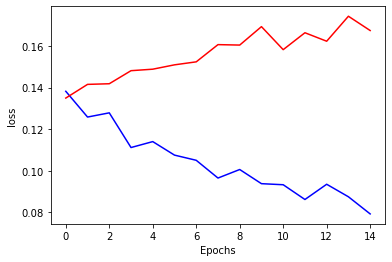

In [231]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [232]:
y_train_pred = model4.predict(X_train)
y_test_pred = model4.predict(X_test)

print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train : ' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test : ' ,  f1_score(y_test,y_test_pred>0.5))

48/48 [==============================] - 0s 5ms/step
accuracy score train : 0.5694413777875911
accuracy score test : 0.5695364238410596
f1 score train :  0.008138351983723296
f1 score test :  0.009146341463414635


These results are very bad. We finally use model2 on sample submission.

In [233]:
sample = pd.read_csv('sample_submission.csv')

In [234]:
test = pd.read_csv('test.csv')

In [235]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [236]:
test['keyword'] = test['keyword'].apply(replace20)

In [237]:
test['text_cleaned']=test['text'].apply(clean_text).apply(lambda x : " ".join(x))
test.head()

,id,keyword,location,text,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear # earthquake different city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting # spokane # wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [240]:
test['keyword_cleaned'] = test['keyword'].apply(clean_keyword)
test.sample(15)

,id,keyword,location,text,text_cleaned,keyword_cleaned
461,1481,body bags,NaN,'Body Bags' (1993) Movie Review!: http://t.co/...,body bags movie review youtube,body bag
728,2369,collapsed,"(queer, trans, he/him, black)",i remember when i was little and i didnt want ...,remember little want pledge school collapse pi...,collapse
2494,8323,rubble,West Coast,@KurtSchlichter Grandpa fought his way across ...,kurtschlichter grandpa fight way western eurp...,rubble
2054,6899,mass murderer,U.S.,RT greta: Movement to impeach SA Pres #Zuma Û...,greta movement impeach sa pres zuma ûò accus...,mass murderer
515,1682,bridge collapse,New York City & Mpls/St. Paul,Throwback Thursday: More Thoughts About Citize...,throwback thursday thought citizen media minne...,bridge collapse
1049,3443,derail,"Washington, DC and on planes",@vivigraubard of course not. for efforts to ad...,vivigraubard course effoaddress sho sideness ...,derail
174,566,arson,"Saginaw, Mich.",RT Saginaw - Police sketches of 2 'persons of ...,saginaw police sketch person interest saginaw ...,arson
399,1292,bloody,Northampton,Im so bloody excited to see Maisy and Martha,bloody excited maisy martha,bloody
1102,3624,desolation,#Global,#NowPlaying - Lamb of God - Desolation http:/...,nowplaying lamb god desolation,desolation
2282,7624,pandemonium,lagos,: Pandemonium In Aba As Woman Delivers Baby Wi...,pandemonium aba woman deliver baby face photo,pandemonium


We drop @ and #.

In [241]:
test['text_cleaned'] = test['text_cleaned'].apply(lambda x : re.sub(r'[@#]','',x))
test.sample(15)

,id,keyword,location,text,text_cleaned,keyword_cleaned
2415,8077,rescue,NaN,Officials rescue 367 migrants off Libya; 25 bo...,official rescue migrant libya body find fox ne...,rescue
989,3268,demolish,Global,Enugu Government to demolish illegal structure...,enugu government demolish illegal structure in...,demolish
709,2310,collapse,"Kampala, Uganda",Greece's tax revenues collapse as debt crisis ...,greece tax revenue collapse debt crisis continue,collapse
1641,5533,flattened,"Salford, Greater Manchester",Zouma! Runaway train. Absolutely flattened the...,zouma runaway train absolutely flatten fiorent...,flatten
2810,9340,survive,NaN,Took the time to finally install #win10 on one...,time finally install win system let survive w...,survive
1740,5866,hailstorm,"Calgary, Alberta",here is goes again #abstorm #hailstorm #yychai...,abstorm hailstorm yychail stay safe,hailstorm
3093,10238,volcano,Desde Republica Argentina,#Sismo M 1.9 - 5km S of Volcano Hawaii: Time20...,sismo km volcano hawaii time utc epicente cs,volcano
1345,4434,electrocute,"Milan, Lombardy",Do you remember when I suddenly electrocute yo...,remember suddenly electrocute death fox power ...,electrocute
654,2137,catastrophe,London UK,Gaza 2014 - The Summer of Catastrophe https://...,gaza summer catastrophe gaza palestine isra...,catastrophe
73,236,airplane accident,NaN,#BreakingNews Experts in France begin examinin...,breakingnews experts france begin examine air...,airplane accident


In [242]:
test['keyword_cleaned'].unique()

array(['', 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilate', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'avalanche',
       'battle', 'bioterror', 'bioterrorism', 'blaze', 'bleeding', 'blow',
       'blight', 'blizzard', 'blood', 'bloody', 'body bag',
       'body bagging', 'bomb', 'bombing', 'bridge collapse',
       'building burn', 'building fire', 'burn', 'burning',
       'burn building', 'bush fire', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collide', 'collision', 'crash', 'crush', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'debris', 'deluge',
       'demolish', 'demolition', 'derail', 'derailment', 'desolate',
       'desolation', 'destroy', 'destruction', 'detonate', 'detonation',
       'devastate', 'devastation', 'disaster', 'displace', 'drought',
       'drown', 'dust storm', 'earthquake', 'electrocute',

In [244]:
text_encoded = tokenizer2.texts_to_sequences(test.text_cleaned)
text_pad = tf.keras.preprocessing.sequence.pad_sequences(text_encoded, padding="post")
text_pad[:5,:]

array([[276,  79,  11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [218,  99, 927, 204, 402,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 78,   1, 527, 421, 155,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [207,  76,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 95, 514,  24, 394, 932,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])

In [245]:
text_pad.shape

(3263, 15)

In [246]:
keywords_encoded = tokenizer2.texts_to_sequences(test.keyword_cleaned)
keyword_pad = tf.keras.preprocessing.sequence.pad_sequences(keywords_encoded, padding="post")
keyword_pad.shape

(3263, 2)

In [247]:
keyword_text_pad = np.concatenate([keyword_pad,text_pad],axis = 1)
keyword_text_pad.shape

(3263, 17)

In [248]:
sample['target']=(model2.predict(keyword_text_pad)>0.5).astype(int)

102/102 [==============================] - 0s 2ms/step


In [250]:
sample.head()

,Unnamed: 0,id,target
0,0,0,1
1,1,2,1
2,2,3,1
3,3,9,1
4,4,11,1


In [258]:
sample = sample.drop(columns = 'Unnamed: 0')

In [259]:
sample.sample(5)

,id,target
1030,3378,0
169,553,1
158,525,0
2615,8731,0
610,1993,0


In [251]:
predict1 = sample[sample.target == 1].index

In [255]:
idx = np.random.randint(len(predict1))

test.loc[predict1].iloc[idx]['text']

"What I'll miss the most is that very rare occasion where you and the first responders on scene are the difference between life and death."

In [257]:
predict0 = sample[sample.target == 0].index

idx = np.random.randint(len(predict1))

test.loc[predict0].iloc[idx]['text']


"seeing more blood and surgery than a regular GP behind a desk and they say dentists aren't  real doctors .... Ok"

In [260]:
sample.to_csv('sample_submission.csv')